In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from typing import Tuple
from numpy.typing import NDArray
from methods.curve_adjusting import cubic_splines, get_spline_func_str
from utils.parser import evaluate_one_variable, get_derivative

# Testes adicionais para interpolação polinomial por splines cúbicos

## Funções auxiliares

In [3]:
def create_empty_dataframes():
    """Cria DataFrames vazios para armazenar resultados"""
    columns = ["points", "real_deriv_1", "real_deriv_2", "natural_deriv_1",
               "natural_deriv_2", "fixed_deriv_1", "fixed_deriv_2",
               "natural_error_1", "natural_error_2", "fixed_error_1", "fixed_error_2"]

    df_5_points = pd.DataFrame(columns=columns)
    df_9_points = pd.DataFrame(columns=columns)

    return df_5_points, df_9_points


def get_real_derivatives(points: NDArray[np.float64], func: str) -> Tuple[NDArray[np.float64], NDArray[np.float64]]:
    """Calcula as derivadas reais de uma função em pontos específicos"""
    real_deriv_1 = np.array([get_derivative(func, 1)(x) for x in points])
    real_deriv_2 = np.array([get_derivative(func, 2)(x) for x in points])
    return real_deriv_1, real_deriv_2

def calculate_spline_derivatives(x: NDArray[np.float64], y: NDArray[np.float64],
                               dx_0: float = None, dx_n: float = None) -> NDArray[np.float64]: # type: ignore
    """Calcula as derivadas do spline em todos os pontos"""
    derivatives_list = np.zeros((2, x.shape[0]), dtype=np.float64)

    # Calcular coeficientes do spline
    if dx_0 is None and dx_n is None:
        coefs = cubic_splines(x, y)  # Natural
    else:
        coefs = cubic_splines(x, y, dx_0=dx_0, dx_n=dx_n)  # Fixado # type: ignore

    # Calcular derivadas em cada ponto
    for i in range(x.shape[0]):
        spline_func = get_spline_func_str(x[i], *coefs, x)
        derivative_func = get_derivative(spline_func, degree=1)
        derivative_func_2 = get_derivative(spline_func, degree=2)
        derivatives_list[0, i] = derivative_func(x[i])
        derivatives_list[1, i] = derivative_func_2(x[i])

    return derivatives_list

def fill_dataframe(df: pd.DataFrame, x: NDArray[np.float64],
                  real_derivs: NDArray[np.float64],
                  natural_derivs: NDArray[np.float64],
                  fixed_derivs: NDArray[np.float64]):
    """Preenche um DataFrame com todos os dados calculados"""
    df["points"] = x
    df["real_deriv_1"] = real_derivs[0, :]
    df["real_deriv_2"] = real_derivs[1, :]
    df["natural_deriv_1"] = natural_derivs[0, :]
    df["natural_deriv_2"] = natural_derivs[1, :]
    df["fixed_deriv_1"] = fixed_derivs[0, :]
    df["fixed_deriv_2"] = fixed_derivs[1, :]
    df["natural_error_1"] = abs(real_derivs[0, :] - natural_derivs[0, :])
    df["natural_error_2"] = abs(real_derivs[1, :] - natural_derivs[1, :])
    df["fixed_error_1"] = abs(real_derivs[0, :] - fixed_derivs[0, :])
    df["fixed_error_2"] = abs(real_derivs[1, :] - fixed_derivs[1, :])

## Configuração

In [4]:
func = "cos(pi * x)"
df_5_points, df_9_points = create_empty_dataframes()

# Pontos
x_5 = np.array([0.0, 0.25, 0.5, 0.75, 1.0], dtype=np.float64)
x_9 = np.array([0.0, 0.125, 0.250, 0.375, 0.5, 0.625, 0.75, 0.875, 1.0], dtype=np.float64)

# Valores de Y para os pontos
y_5 = np.array([evaluate_one_variable(func, el) for el in x_5], dtype=np.float64)
y_9 = np.array([evaluate_one_variable(func, el) for el in x_9], dtype=np.float64)

# Derivadas reais
real_derivs_5 = np.array(get_real_derivatives(x_5, func))
real_derivs_9 = np.array(get_real_derivatives(x_9, func))

# Função derivada para splines fixados
deriv = get_derivative(func)

## Cálculos dos pontos

In [5]:
# Spline Natural e Fixo - 5 pontos
natural_derivs_5 = calculate_spline_derivatives(x_5, y_5) # type: ignore
fixed_derivs_5 = calculate_spline_derivatives(x_5, y_5, dx_0=deriv(x_5[0]), dx_n=deriv(x_5[-1]))

fill_dataframe(df_5_points, x_5, real_derivs_5, natural_derivs_5, fixed_derivs_5)

# Spline Natural e Fixo - 9 pontos
natural_derivs_9 = calculate_spline_derivatives(x_9, y_9) # type: ignore
fixed_derivs_9 = calculate_spline_derivatives(x_9, y_9, dx_0=deriv(x_9[0]), dx_n=deriv(x_9[-1]))

fill_dataframe(df_9_points, x_9, real_derivs_9, natural_derivs_9, fixed_derivs_9)

print("\n" + "="*80)
print("RESULTADOS - 5 PONTOS")
print("="*80)
display(df_5_points)

print("\n" + "="*80)
print("RESULTADOS - 9 PONTOS")
print("="*80)
display(df_9_points)


RESULTADOS - 5 PONTOS


,points,real_deriv_1,real_deriv_2,natural_deriv_1,natural_deriv_2,fixed_deriv_1,fixed_deriv_2,natural_error_1,natural_error_2,fixed_error_1,fixed_error_2
0,0.00,-0.000000e+00,-9.869604e+00,-0.757359,-0.000000,-4.009138e-08,-1.038664e+01,0.757359,9.869604e+00,4.009138e-08,5.170370e-01
1,0.25,-2.221441e+00,-6.978864e+00,-2.000000,-9.941125,-2.216388e+00,-7.344465e+00,0.221441,2.962261e+00,5.053094e-03,3.656011e-01
2,0.50,-3.141593e+00,-6.043390e-16,-3.242641,0.000000,-3.134446e+00,1.608422e-07,0.101048,6.043390e-16,7.146154e-03,1.608422e-07
3,0.75,-2.221441e+00,6.978864e+00,-2.000000,9.941125,-2.216388e+00,7.344465e+00,0.221441,2.962261e+00,5.053094e-03,3.656007e-01
4,1.00,-3.847341e-16,9.869604e+00,-0.757359,0.000000,0.000000e+00,1.038664e+01,0.757359,9.869604e+00,3.847341e-16,5.170376e-01



RESULTADOS - 9 PONTOS


,points,real_deriv_1,real_deriv_2,natural_deriv_1,natural_deriv_2,fixed_deriv_1,fixed_deriv_2,natural_error_1,natural_error_2,fixed_error_1,fixed_error_2
0,0.000,-0.000000e+00,-9.869604e+00,-0.360758,-0.000000e+00,-2.133956e-08,-9.997080e+00,0.360758,9.869604e+00,2.133956e-08,1.274755e-01
1,0.125,-1.202235e+00,-9.118326e+00,-1.105376,-1.191389e+01,-1.202074e+00,-9.236099e+00,0.096860,2.795562e+00,1.617788e-04,1.177731e-01
2,0.250,-2.221441e+00,-6.978864e+00,-2.247177,-6.354926e+00,-2.221143e+00,-7.069003e+00,0.025735,6.239380e-01,2.989344e-04,9.013907e-02
3,0.375,-2.902453e+00,-3.776934e+00,-2.894624,-4.004236e+00,-2.902063e+00,-3.825717e+00,0.007829,2.273024e-01,3.905728e-04,4.878321e-02
4,0.500,-3.141593e+00,-6.043390e-16,-3.144889,2.924890e-08,-3.141170e+00,9.279147e-08,0.003296,2.924890e-08,4.227549e-04,9.279147e-08
5,0.625,-2.902453e+00,3.776934e+00,-2.894624,4.004236e+00,-2.902063e+00,3.825717e+00,0.007829,2.273023e-01,3.905738e-04,4.878300e-02
6,0.750,-2.221441e+00,6.978864e+00,-2.247177,6.354926e+00,-2.221143e+00,7.069004e+00,0.025735,6.239379e-01,2.989325e-04,9.013935e-02
7,0.875,-1.202235e+00,9.118326e+00,-1.105376,1.191389e+01,-1.202074e+00,9.236098e+00,0.096860,2.795562e+00,1.617810e-04,1.177727e-01
8,1.000,-3.847341e-16,9.869604e+00,-0.360758,0.000000e+00,0.000000e+00,9.997081e+00,0.360758,9.869604e+00,3.847341e-16,1.274763e-01


## Análise dos erros

In [6]:
print("\n" + "="*80)
print("ANÁLISE DOS ERROS")
print("="*80)

# Erros médios primeira derivada
print("ERROS MÉDIOS - PRIMEIRA DERIVADA:")
print(f"  Natural (5 pontos):  {df_5_points['natural_error_1'].mean():.8f}")
print(f"  Fixado (5 pontos):   {df_5_points['fixed_error_1'].mean():.8f}")
print(f"  Natural (9 pontos):  {df_9_points['natural_error_1'].mean():.8f}")
print(f"  Fixado (9 pontos):   {df_9_points['fixed_error_1'].mean():.8f}")

# Erros máximos primeira derivada
print("\nERROS MÁXIMOS - PRIMEIRA DERIVADA:")
print(f"  Natural (5 pontos):  {df_5_points['natural_error_1'].max():.8f}")
print(f"  Fixado (5 pontos):   {df_5_points['fixed_error_1'].max():.8f}")
print(f"  Natural (9 pontos):  {df_9_points['natural_error_1'].max():.8f}")
print(f"  Fixado (9 pontos):   {df_9_points['fixed_error_1'].max():.8f}")

# Erros médios segunda derivada
print("\nERROS MÉDIOS - SEGUNDA DERIVADA:")
print(f"  Natural (5 pontos):  {df_5_points['natural_error_2'].mean():.8f}")
print(f"  Fixado (5 pontos):   {df_5_points['fixed_error_2'].mean():.8f}")
print(f"  Natural (9 pontos):  {df_9_points['natural_error_2'].mean():.8f}")
print(f"  Fixado (9 pontos):   {df_9_points['fixed_error_2'].mean():.8f}")

# Comparação de performance
print("\n" + "="*50)
print("MELHOR MÉTODO POR CRITÉRIO:")
print("="*50)

methods = ["Natural (5)", "Fixado (5)", "Natural (9)", "Fixado (9)"]
errors_1 = [df_5_points['natural_error_1'].mean(), df_5_points['fixed_error_1'].mean(),
           df_9_points['natural_error_1'].mean(), df_9_points['fixed_error_1'].mean()]
errors_2 = [df_5_points['natural_error_2'].mean(), df_5_points['fixed_error_2'].mean(),
           df_9_points['natural_error_2'].mean(), df_9_points['fixed_error_2'].mean()]

best_1 = methods[np.argmin(errors_1)]
best_2 = methods[np.argmin(errors_2)]

print(f"Melhor para 1ª derivada: {best_1} (erro: {min(errors_1):.8f})")
print(f"Melhor para 2ª derivada: {best_2} (erro: {min(errors_2):.8f})")


ANÁLISE DOS ERROS
ERROS MÉDIOS - PRIMEIRA DERIVADA:
  Natural (5 pontos):  0.41172992
  Fixado (5 pontos):   0.00345048
  Natural (9 pontos):  0.10951771
  Fixado (9 pontos):   0.00023615

ERROS MÁXIMOS - PRIMEIRA DERIVADA:
  Natural (5 pontos):  0.75735931
  Fixado (5 pontos):   0.00714615
  Natural (9 pontos):  0.36075775
  Fixado (9 pontos):   0.00042275

ERROS MÉDIOS - SEGUNDA DERIVADA:
  Natural (5 pontos):  5.13274628
  Fixado (5 pontos):   0.35305532
  Natural (9 pontos):  3.00364598
  Fixado (9 pontos):   0.08537137

MELHOR MÉTODO POR CRITÉRIO:
Melhor para 1ª derivada: Fixado (9) (erro: 0.00023615)
Melhor para 2ª derivada: Fixado (9) (erro: 0.08537137)


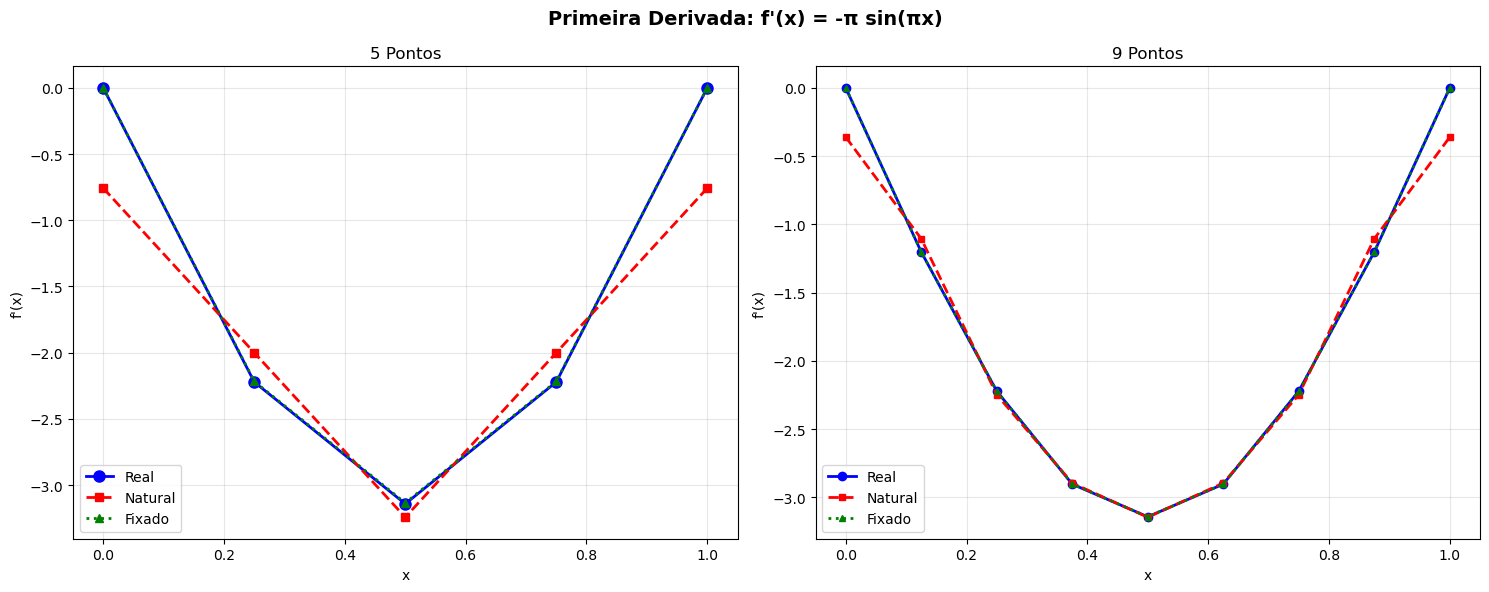

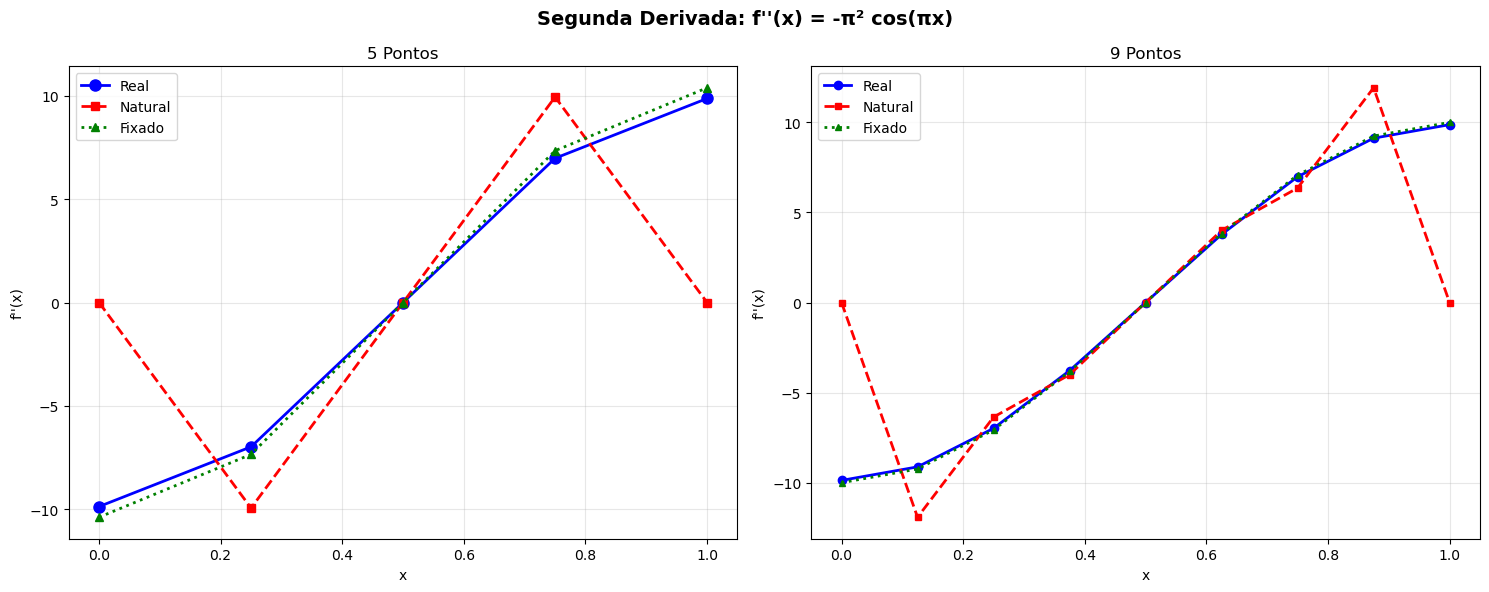

In [7]:
# Gráfico da Primeira Derivada
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Primeira Derivada: f\'(x) = -π sin(πx)', fontsize=14, fontweight='bold')

# 5 pontos
ax1.plot(x_5, real_derivs_5[0, :], 'o-', color='blue', linewidth=2, markersize=8, label='Real')
ax1.plot(x_5, natural_derivs_5[0, :], 's--', color='red', linewidth=2, markersize=6, label='Natural')
ax1.plot(x_5, fixed_derivs_5[0, :], '^:', color='green', linewidth=2, markersize=6, label='Fixado')
ax1.set_title('5 Pontos', fontsize=12)
ax1.set_xlabel('x')
ax1.set_ylabel("f'(x)")
ax1.grid(True, alpha=0.3)
ax1.legend()

# 9 pontos
ax2.plot(x_9, real_derivs_9[0, :], 'o-', color='blue', linewidth=2, markersize=6, label='Real')
ax2.plot(x_9, natural_derivs_9[0, :], 's--', color='red', linewidth=2, markersize=4, label='Natural')
ax2.plot(x_9, fixed_derivs_9[0, :], '^:', color='green', linewidth=2, markersize=4, label='Fixado')
ax2.set_title('9 Pontos', fontsize=12)
ax2.set_xlabel('x')
ax2.set_ylabel("f'(x)")
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

# Gráfico da Segunda Derivada
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Segunda Derivada: f\'\'(x) = -π² cos(πx)', fontsize=14, fontweight='bold')

# 5 pontos
ax1.plot(x_5, real_derivs_5[1, :], 'o-', color='blue', linewidth=2, markersize=8, label='Real')
ax1.plot(x_5, natural_derivs_5[1, :], 's--', color='red', linewidth=2, markersize=6, label='Natural')
ax1.plot(x_5, fixed_derivs_5[1, :], '^:', color='green', linewidth=2, markersize=6, label='Fixado')
ax1.set_title('5 Pontos', fontsize=12)
ax1.set_xlabel('x')
ax1.set_ylabel("f''(x)")
ax1.grid(True, alpha=0.3)
ax1.legend()

# 9 pontos
ax2.plot(x_9, real_derivs_9[1, :], 'o-', color='blue', linewidth=2, markersize=6, label='Real')
ax2.plot(x_9, natural_derivs_9[1, :], 's--', color='red', linewidth=2, markersize=4, label='Natural')
ax2.plot(x_9, fixed_derivs_9[1, :], '^:', color='green', linewidth=2, markersize=4, label='Fixado')
ax2.set_title('9 Pontos', fontsize=12)
ax2.set_xlabel('x')
ax2.set_ylabel("f''(x)")
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()